In [22]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta  
import threading

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

def execRangeQuery(params_dic,dates):
    query = """
    SELECT
    sum(count_)
    FROM _775147
    WHERE
    time_ >= '{date0}'
    AND time_ <=  '{date1}'
    ;
    """.format(date0 = dates[0], date1 = dates[1])
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")

def execQuery(params_dic,query):
    try:
        connection = psycopg2.connect(**params_dic)
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            print("Executed query and closed connection.")
#"""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;"""
query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)
"""
print(result)
print(type(result))
print(type(result[0]))
print((str(result[0][0])))
"""
counts = [(count[0]) for count in result]

Executed query and closed connection.
Executed query and closed connection.


In [3]:
def add_missing_dates(old_dates):
    start_date = dates[0]
    end_date = dates[-1]
    all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
    return [(date.date()) for date in all_dates]
    
def add_missing_counts(old_counts, old_dates, new_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(new_dates))
        for i, date in enumerate(new_dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts

In [4]:
all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

In [5]:
np.random.uniform(-1,0,1000)
def randomized_response(x, p=0.1):
    if np.random.uniform(0,1) < p:
        return x
    else:
        return np.random.randint(2)

In [6]:
randomized_response(1)

1

In [7]:
def get_index(date_idx, n_layers):
    """Calculates the path of index in full binary string

    Parameters:
    date_idx (int): The node in the bouttom layer we want to calculate a path to. 
    The bottom layer has index from 0 to 2**h-1
    n_layers (int): The height of the full binary tree. starts from 0 

    Returns:
    list: of index in the path from the starting from the bottom and going up

    """
    idx = []
    for i in np.arange(0,n_layers):
        if i == 0:
            idx.append(int(date_idx))
        else:
            idx.append(int(idx[i-1]//2))
    idx.append(0)
    return idx

def left_or_right(current, nxt):
    #0 is left 1 is right
    #print(f'current = {current}, nxt = {nxt}')
    if nxt == 0:
        #print('nxt == 0')
        return 0
    if current == 0 and current < nxt:
        #print('current == 0 and current < nxt')
        return 1
    elif 2* current < nxt:
        #print('2* current < nxt')
        return 1
    else:
        #print('else')
        return 0
    
def left_or_right_list(path):
    #print(path)
    #0 is left 1 is right
    direction_lst = []
    for i in range(len(path)-1):
        #print(f'i = {i}')
        current = path[i]
        nxt = path[i+1]
        #print(f'current = {current}, nxt = {nxt}')
        if nxt == 0:
            #print('nxt == 0')
            direction_lst.append(0)
        elif current == 0 and current < nxt:
            #print('current == 0 and current < nxt')
            direction_lst.append(1)
        elif 2* current < nxt:
            #print('2* current < nxt')
            direction_lst.append(1)
        else:
            #print('else')            
            direction_lst.append(0)
            
    return direction_lst

In [8]:
def HH_OUE(dates, counts, OUE, epsilon):
    h = int(np.ceil(np.log2(len(dates))))
    prob = np.full(h+1,1/(h+1))
    print(f'h = {h}')
    
    tree_levels = []
    for i in np.arange(0,h+1):
        level = np.zeros(int(2**np.ceil(i)))
        tree_levels.append(level) 
    
    #OUE response
    vfunc = np.vectorize(OUE, otypes = [int])
    
    
    for index, (date, day_count) in enumerate(zip(dates, counts)):
        #print(f'index = {index}, date = {date}, count = {day_count}')
        idxs = get_index(index,h)
        idxs.reverse()
        
        for person in range(int(day_count)):
            #print(person)
            level = np.random.choice(np.arange(0, h+1), p = prob ) 
            #print(f'we got level = {level}')
            tree_level = np.zeros(2**level,dtype=int)
            #print(idxs[level])
            #tree_level[index] = 1
            #get_index
            tree_level[idxs[level]] = 1
            perb_tree_level = vfunc(tree_level,epsilon)
            tree_levels[level] = tree_levels[level] + perb_tree_level
        #print(f'index = {index}, date = {type(date)}, count = {count}')
        #print(index, value1 + value2)  # for Python 2 use: `print index, value1 + value2` (no braces)
    return tree_levels

In [18]:
class HH_OLH_cc:
    def __init__(self, epsilon, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        if len(dates) < (dates[-1]-dates[0]).days:
            print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.h = int(np.ceil(np.log2(len(self.all_dates))))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        #Check if we are we have missing dates.
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(2**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            #print(f'index = {index}, date = {date}, count = {count}')
            idxs = self.get_index(index,self.h)
            idxs.reverse()

            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(2**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (2**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up
        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//2))
        idx.append(0)
        return idx
    
    def OLH_func(self, correct_answear, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        if np.random.uniform(0,1) < p:
            #print('if')
            return correct_answear
        else:
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count - (1-p)*N/g) / (p)
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]

        idx_left = idx_0-1
        idx_right = idx_1+1

        path_to_left = np.flip(np.array(get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(get_index(idx_right,self.h)))

        if idx_0 == 0:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            sum_level = 0.0
            #sum_all = 0.0
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    #print('Node')
                    #print(node)
                    #print('With all')
                    #contribution_all = self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #sum_all = sum_all + self.OLH_aggre(node, np.sum(self.all_counts), len(self.all_dates))
                    #print(contribution_all)
                    #print('with level')
                    contribution_level = self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                    sum_level = sum_level + contribution_level
                    #print(self.tree_levels[i+level_offset])
                    #print(contribution_level)
                    #print(np.sum(self.tree_levels[i+level_offset]))
                    #print(len(self.tree_levels[i+level_offset]))
                    
            #print('____________________________')
            #print(sum_level)
            #print(sum_all)
            return sum_level * (self.h+1)
            
        elif idx_1 == np.max(self.idx_dict.values):
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
        else:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])

            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    

        print(all_counts[idx_0:idx_1])
        print(f'Real answer is {np.sum(all_counts[idx_0:idx_1+1])}')
        #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
        #D = len(all_dates)
    def real_answer(self, dates):
        if len(dates) < 2:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            return self.all_counts[self.idx_dict[date_obj_0]]
        else:
            date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
            date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()
            #print(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])
            sum_ = np.sum(self.all_counts[self.idx_dict[date_obj_0]: self.idx_dict[date_obj_1]+1])  
            return sum_ 

query_dates = ('2014-01-02','2014-01-9')
epsilon = 100
local_HH = HH_OLH_cc(epsilon, all_dates[:32], all_counts[:32])

print(local_HH.answer(query_dates))
print(np.sum(all_counts[:8]))

for level in local_HH.tree_levels:
    print(level)


1668.0
1681.0
[1000.]
[505. 531.]
[278. 236. 255. 251.]
[ 76. 219.  58. 179. 119.  92. 154. 132.]
[ 57.  17. 103.  74.  34.  39. 110.  63.  14. 115.  87.  16.  41. 111.
  61.  51.]
[40. 21. 27.  0. 55. 63. 45. 41.  8. 13.  0. 48. 59. 39.  0. 61.  9.  1.
 35. 71. 52. 43.  8. 14.  1. 42. 49. 43. 43. 16. 36. 20.]


In [13]:
294*6

1764

In [14]:
print(local_HH.h)

5


In [15]:
#Sanity check
print(np.sum(all_counts[:2]))
sum_levels = [np.sum(a) for a in local_HH.tree_levels]
sum_all_levels = np.sum(sum_levels)
print(f'Expected sum of levels = {sum_all_levels/len(local_HH.tree_levels)}')
print(sum_levels)
"""
for level in local_HH.tree_levels:
    print(level)
    level_sum = np.sum(level)
    print(f'Sum of level = {level_sum}')
"""

357.0
Expected sum of levels = 1013.5
[949.0, 1011.0, 1008.0, 1045.0, 1044.0, 1024.0]


"\nfor level in local_HH.tree_levels:\n    print(level)\n    level_sum = np.sum(level)\n    print(f'Sum of level = {level_sum}')\n"

In [26]:
def plot_estimates_flat(number_of_queries, N, model, epsilon, dates, counts, range_qurey, plot_name):
    
    test_dates, test_counts = dates[:N].copy(), counts[:N].copy()
    answers = np.zeros(number_of_queries)
    

    for i in range(0,number_of_queries):
        current_model = model(epsilon, test_dates, test_counts)
        answer = current_model.answer(range_qurey)
        answers[i] = answer
    print(answers)
    correct_answer = current_model.real_answer(range_qurey)
    
    x = np.arange(0,number_of_queries)
    answers.sort()

    plt.scatter(x,answers, marker = '+', label="Esitmates")
    plt.axhline(np.mean(answers),linewidth=0.5, color='r', linestyle = '-', label="Mean of esitmates ")
    plt.axhline(correct_answer,linewidth=.4, color='b', linestyle = '--', label="Correct answer")
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    plt.legend()
    plt.title(f'Flat OLH with N = {N} and \u03B5 = {epsilon}')
    plt.savefig(plot_name)
    plt.show()
    return answers

[1786.99117367 1584.21829941 1608.84012935 1804.36934373 1658.70561918
 1591.45369222 1853.41123835 1919.20947309 2065.28499525 1948.58764314
 1670.08378923 1596.00826707 1945.47849344 1554.83186228 1551.10914971
 1561.04189462 2057.00770782 1669.88202397 1558.96637246 1782.84839642
 1618.75634012 1621.67199163 1636.36107666 1717.25192696 1639.46195929
 2230.4106791  1597.45369222 1855.47022637 1806.43659882 1612.13451018
 2025.97408028 1785.12568385 1552.76460719 1559.5882024  1400.26075328
 1560.42006468 1777.88202397 1919.62127069 1696.36107666 1474.95810538
 1403.15987065 1722.02480122 1812.22656648 1777.26019403 1754.29382157
 1688.08378923 1743.94927906 1564.14277725 1801.6802587  1684.9829066
 1540.14277725 1527.93274491 1372.33627544 1641.73097965 1871.62127069
 1712.70561918 2095.50329466 1945.27672817 1725.73924672 1345.02536047
 1656.84012935 1662.21829941 1577.38643713 1471.24365988 1830.64663116
 1528.55457485 1431.50441316 1389.3026479  1798.1593114  1245.49614609
 1677.5

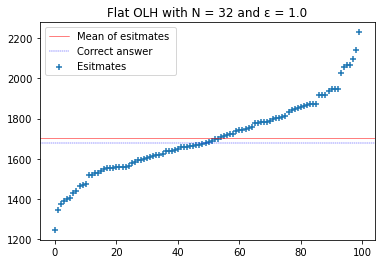

In [27]:
range_dates = ('2014-01-02','2014-01-9')    
epsilon = 1.
number_of_queries = 100 
N = 32
a = plot_estimates_flat(number_of_queries, N, HH_OLH_cc, epsilon, all_dates, all_counts, range_dates, '1234.png')


[1751.68285991 1572.87927201 1634.18737731 1800.38195643 1418.16577186
 1585.30810529 1858.82519334 1712.63781603 1899.87743903 1843.78014947
 1675.84863177 1766.20898275 1762.7351056  1725.76574584 1769.34411437
 1787.77294765 1640.79638608 1809.4270003  1542.78918427 1769.77294765
 1371.6324472  1798.21618457 1777.41979849 1861.69006172 1395.99279819
 1516.78198245 1685.41259667 1588.71350015 1604.97656157 1571.14233343
 1376.07568412 1553.66125446 1689.76574584 1617.92431588 1468.26306142
 1422.85766657 1394.77478064 1740.56213192 1494.51892103 1540.53332466
 1726.5549301  1742.81799153 1822.39636006 1808.11889501 1532.79638608
 1574.61621059 1853.00536883 1641.4954826  1492.17297368 1567.75854402
 1605.40539486 1576.8720702  1654.28466687 1677.58557035 1547.57116672
 1699.93871951 1490.34594735 1746.11169319 1550.52612284 1663.50988623
 1775.68285991 1742.72790378 1904.50085143 1678.98376339 1750.8035879
 1721.16393888 1569.4954826  1680.72070197 1345.89550862 1679.68285991
 1660.7

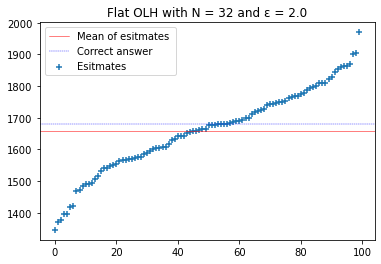

[1798.81078971 1458.0180696  1954.64257387 1278.06616844 1364.99707515
 1628.47448815 1413.59766012 1257.59168029 1921.50744225  993.03321434
 1542.02404942 1262.06616844 1226.78089058 2333.71153705 1714.39038023
 1696.24023399 1759.17114069 1694.69067272 1108.14429653  726.51075746
 1561.30932728 1678.98498538 1782.27624306 1565.24926879 1907.41735451
 1526.79883006 1145.69983763 1443.80786486 1650.03002925 1728.60058497
 1680.60058497 1468.04809884 1772.00597983 1979.36327584 1355.86194353
 2339.26707815 1718.81078971 2136.02391931 1814.63659405 1570.08410792
 1419.56763087 1719.34533636 1832.13207665 1493.66369844 1689.4954826
 2129.6395189  2005.27318809 2176.74462127 1654.21020474 1542.19824509
 1490.0180696  2093.33922642 1101.63977913 1666.80480988 2164.39025011
 1384.40247    1429.71777711 2254.2460837  1960.43834896 1574.62463439
 1592.53454665 2201.70555722 1379.08716289 2398.84666867 1211.31543723
 1735.82580434 2202.89476751 1978.10802722 1314.24634393 1955.36327584
 2254.5

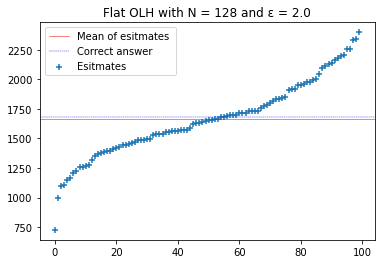

[ 1589.44374395  1064.52050721  1036.56106621  1338.98888541
  2384.87253799  2719.91407183  2641.33077645  3286.84406841
  2838.5142668  -1513.51914098  4789.05076277  1499.52824188
   214.48813828  1197.08352309   889.30997752  1536.8469289
  2041.11251209   514.28534327  2210.97731542  1150.45628878
  2380.20136477   891.99129049  1284.35151136  3224.21345419
  2171.01111459   401.01397508  1412.2602536   1114.46980845
  1280.35489128  1734.67117322  2938.44666846    97.91160273
   530.91257757   646.17380601  1806.6272343   3479.37328513
  -193.20090936  2869.13812119  2474.78804007  1889.24094894
   899.3268771   1809.94930125  3015.69775715  1573.44036404
  2492.1067271   2049.10575226  1289.69723772  1384.94156658
 -1175.10484144   836.03860933   220.4915182   1728.02703934
  1961.83776399   345.73584705  -165.2076692    257.13565208
  1001.23223943  2945.76535549  1403.60935988  2134.3669807
  2655.98505009  2641.31387687   957.92707207   115.24718934
  2829.84647349  -657.5171

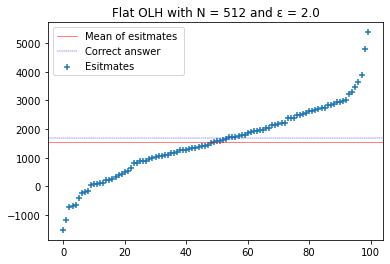

[ 5581.04751245  4020.51712625  3535.47845238   830.57237597
 -3796.95911415 -3125.62209781   235.53149219  -621.57347989
  6229.47182163  8423.19115789 -5945.3834228   8682.96132354
  7100.45966663 10206.96132302  1727.17790053 -4377.44088191
  5751.84530245    76.99889557  1355.37679568 -4645.97568844
   138.47071875   353.62209989  9166.38231785 11085.09612934
   576.86187881   728.65856385 -3514.80662806  5941.79005376
  1094.93038693   854.83756933 13362.25855949  5969.02541288
 -1929.06961203  4031.84088315   -22.35580054 -4303.02762227
  1690.23646407 12156.67623947 -2867.05856198  -354.65635291
  -819.60662899 14470.51491271 -3001.32596525  8797.55137875
  4207.22651845  2899.05414321  1233.37458577 -2109.308286
  7921.03425198  6606.39115851  6287.0320426   6789.1889485
 -1389.70607631  4427.23093827 -3268.24309223  3574.97900486
 -5381.75469371 -8429.34364294  -809.22430855  -324.86187778
  1044.78232065  1611.64640885 -3226.85966683 -2810.43977747
   707.62872961  1755.61988

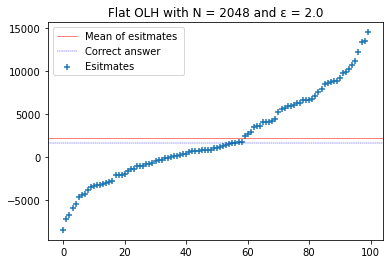

[1741.44584801 1795.85894744 1558.23219564 1624.8133759  1827.3817332
 1662.16808083 1619.96153112 1744.11678899 1559.50996281 1857.13671461
 1554.65811803 1969.12389165 1724.31051575 1685.63957476 1639.03274858
 1778.10396603 1532.42592239 1970.89169601 1778.51706546 1551.98717704
 1818.58118026 1503.08404042 1413.61254649 1889.80765559 1651.9358852
 1638.61964915 1503.81909621 1640.80055294 1738.98145673 1362.9416055
 1414.72223283 1435.80627325 1576.60682618 1781.22647533 1576.85184478
 1701.21365237 1772.10396603 1685.67804364 1841.39455616 1614.16808083
 1493.34188197 1819.65239772 1665.70368956 1460.67094099 1708.5683573
 1545.78062732 1641.70368956 1627.27776717 1680.33616167 1747.16236053
 1674.37463055 1877.84612448 1782.58118026 1447.80627325 1520.21937268
 1709.22647533 1571.30341309 1784.76208406 1693.65239772 1701.00710265
 1656.78772998 1476.41309943 1623.70368956 1587.29059013 1738.52988842
 1260.77352467 1845.3817332  1875.3817332  1776.78772998 1674.37463055
 1581.3290

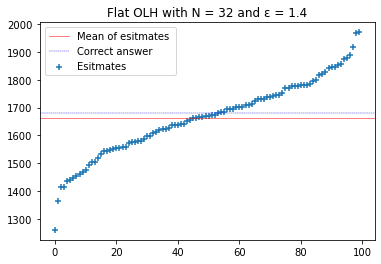

[ 814.79028844 1375.00907306 1575.91359203  596.12270021 1860.04458633
 1080.42651045 1225.20141746  789.54290229 1890.1951091  1714.62438425
  877.67251424 1978.84040417 1898.15190512 1317.63207496 2164.99230929
 1594.96725142 1441.50384536 2812.05011573 1492.08502562 1635.65575047
 1529.03136623 1872.90451897 1158.0613501  2467.5748719  2708.00691175
 1800.21601992 1218.40559963 1610.40836433 1393.46064137 1257.88991652
 1153.76030456 1771.82856641 1508.6871167  2197.03551327 1379.8690057
 1187.00769071 1779.26967931  928.21049052 2221.07871726 1069.37285105
 1706.53797628 2128.0027647   758.74708446 1519.78398008 1182.70664517
 1693.54843169 2230.92819449 1562.92404744 1218.44880361 1694.79581784
 2252.51983016 1442.7512315  2030.02367552  743.95126662 1044.03905694
 1733.72124763 1802.66758823 1577.76306926 1346.06273245  717.41329034
 1521.67666129  511.64883873 1502.53659393 1772.47386148 1596.81672865
 1085.32964707 2087.35746963 1216.64253037 1091.52337382 1437.2460038
 1367.56

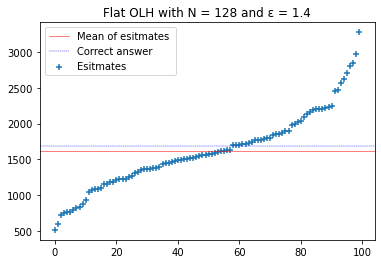

[ 2314.32679458  1249.36710497  6501.34238712  3001.87248213
   344.90862491  1891.37194319 -2772.87288938  -156.59500376
   945.3567579    291.21472536  -720.0510647   2266.06826185
  6253.16313392  3172.95418077 -3220.39237395   801.55737585
  2408.99691027 -1480.71016271  1466.27989748  2413.56154345
  5387.83392023  2017.59876411   793.98481471  4067.12241628
   190.81899831  2191.10790162  5791.9497498   -315.24926354
  1976.33230342  1395.0134368   -900.55227426  1617.07135158
 -1009.49677859  1346.17441497   736.30677107  3252.76941873
  -567.12241628  5672.42475638 -1177.28030473  2627.17616347
  4932.74187452  3517.94074398  -134.45780944  5084.40406226
 -1729.76014954  1579.78903499  1908.36401524  1283.64149361
  1711.45122272   542.69215106 -1184.27237678  3226.35783577
  1237.81039974   -44.93281602 -2366.91011003  -253.11206922
  1057.01894564  2022.45364184  3214.22064146  -219.41816967
 -2641.50094619  2644.45848006  1149.84211155  5298.30892681
  4106.25168265  1702.32

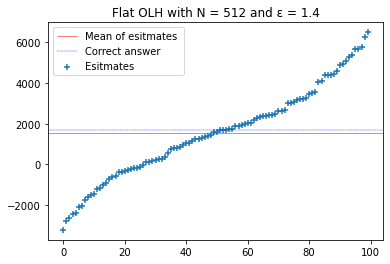

[  -897.46368442   -995.15379279  -2144.92906595  -3760.63540664
  -4087.60990512   5583.04730435   -862.51159773    196.30710638
   9507.35658703    600.12890022  -2327.89011736  -9574.77823313
  -4748.2924414     -42.65842738   3704.79459522   7248.86291873
   7095.79707599 -13284.12198205  -8451.74098164   3091.69289362
  -2244.728448     8513.59476094   4058.50711537  10415.42830476
  -7858.6437624  -12558.38256775   2805.35610784  -4258.78053919
   4695.81839963  14080.34840599   4300.42025347  -2929.20140162
  -3400.81809516  -3908.01562337 -18567.27686298 -11983.5997225
    370.21576212   1369.66321422  -8410.2649383   -4804.29692376
  12308.2094529   15144.43357078   5190.59676253    -98.66290974
  -6643.81161122 -15097.1082305    7646.78950391   7644.05148223
   1626.10479133   5963.28826352  11993.02537176  -2286.41407401
  -2805.40201956  17626.94516851  -3813.482702     7755.85086429
    803.51359931 -10376.73619481   9127.11562787   -706.288568
  -2516.32721211   3138.8545

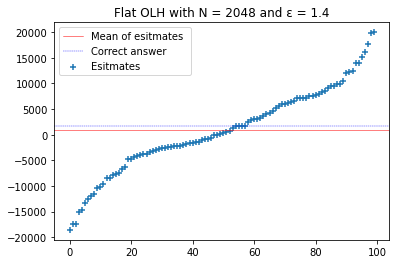

[1610.6973521  1571.79823473 1671.32744912 1264.94983831 1853.40297128
 1466.68908503 1817.61300362 1678.97463953 1791.32744912 1706.70561918
 1744.571109   1764.44486589 1448.26902035 1575.52094731 1547.5882024
 1729.88202397 1637.59646947 1604.49558684 1561.86548982 1368.40353053
 1675.88202397 1819.05842876 1852.99117367 1735.8737569  1374.61356287
 1749.94927906 1813.88202397 1560.         1871.41123835 1806.8566635
 1673.18467187 1676.6973521  1916.51212098 1831.05842876 1777.26019403
 1355.15160358 1608.21829941 1406.05898802 1584.21829941 1881.75578087
 1559.79823473 1670.89911737 1749.94927906 1743.53748145 1313.77343352
 1960.37761081 1891.07496291 1724.09205631 1418.47078562 1588.76460719
 1969.89855811 1751.3947042  1528.96637246 1567.65545749 1731.94927906
 1608.21003234 1821.74751379 1937.20947309 1483.86548982 1582.97463953
 1553.17640479 1719.53748145 1392.19349819 1670.2855545  1624.36107666
 1590.         1497.10088263 1556.27728743 1655.3947042  1554.62182994
 1930.58

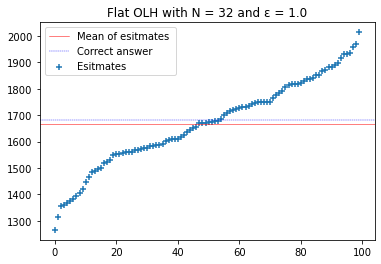

[1032.45812567  811.46695199 1414.58600596  997.42174243 2715.74252109
 2193.45532941  660.27125736 2167.25080845 1564.67255088 2072.05511382
 2141.03250904 1129.3037664  2021.01873058  325.32529325 2194.28719168
  755.73046097 1454.58600596 2029.29601801  887.33519751 1226.13562868
 1008.7354131  1201.87211971 2357.89192823 1845.54574853 1642.48180838
 1852.99117367  719.03035317 2726.22432947 1230.28116162 1240.48568258
 3120.20667682 2064.33240125 1132.34014964 1098.67642508 1249.31754486
 1853.2684611  3131.79763491 2661.11517977 2737.81528756 1638.33627544
 1389.19956883 2201.73261683 1508.65877243  969.55349692 1523.28611375
 1667.85446706 1372.09041912  723.45317354 2433.49666477 1238.55844905
 1920.02755691 2456.38751506 1386.16318559  491.96641303 2178.55070066
 2362.85554499 2156.20064676 1825.67750301 1558.32249699  983.07168854
 2329.74639529 3634.49386851 2325.6146408  1282.96749096 1072.7354131
 2122.82798808  924.31259273 1820.99117367 1257.87211971  793.52594001
 1321.0

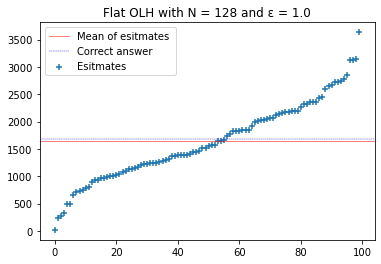

[-1461.57202067  4221.96017812  3028.65468543  1387.00473535
  3779.13046773  6949.30571742  1512.88675932  2363.89537284
  3580.98773304 -5632.42477536  3608.06480527  2460.80689082
  1523.58514481 -3380.50076569  4836.7194907   1621.36060253
 -2007.85749004  3991.92400967  1278.36533788  2411.83638483
  1141.61937416 -1404.66050269  2508.7479028   -875.08482858
  4651.16857526  -502.78794942  1542.72120506  -328.10097372
  -808.87169609  2486.15608356  1222.15220539  6723.92035623
   468.75349533  3518.3959138   2689.81356525  -348.96491347
 -1486.22282792   878.99138648  5879.98881495  2481.5052763
 -1368.4473702   1465.64413282 -5096.30486024  5441.64435755
  -458.46825068   445.13218208 -2397.92982693  -335.34360022
  3551.85167278   292.17308587 -1227.21615349 -4230.64543946
  3251.28267311  3941.39117845  1794.31969874 -4626.39807761
 -1201.86696074  1796.21313249  1990.03616844  3426.99914282
  4187.64047938  2529.61184255  -934.75372006 -1638.31798438
  2633.76598702  1496.508

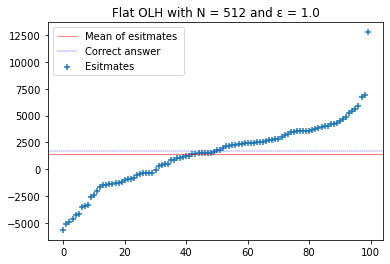

[ -3129.91518931   3334.58009025 -13281.36882027  -5848.27364591
  -4113.72046621 -21979.69704402   2167.27976449   5545.23456288
   7745.90249078  15815.41553536 -20069.2515065    8790.07816608
  13049.87860719  -2720.9654574    7323.76083203 -36866.68201061
  -4649.0002307  -17244.16570838  -2628.62196955  15011.89992521
  -6973.9847359    1719.94617891   4702.14317222  21306.09208274
 -14758.86462587  -4429.13478343  11364.51735432   1546.06727637
   8352.73112522  -8888.82758236  -3368.56179919  10856.81337034
  -7233.42596367 -18214.77905844  -2954.0228315  -11745.88646994
  18837.18830918  12358.30917595  22408.62470116  -7035.54706113
   9160.64404431    371.16425955 -12425.08550278  11884.5917367
 -17886.17281438  -8022.55772014   6248.80399412   1649.58923578
 -11888.61381146   9005.54630439 -27596.70362398  -3318.99947396
   -724.95759466  -1975.80679038  17611.53104029  -4144.50162883
   8613.36427983  14862.39142107  12828.82123309  -3516.87837649
   2780.51916315  -3999.39

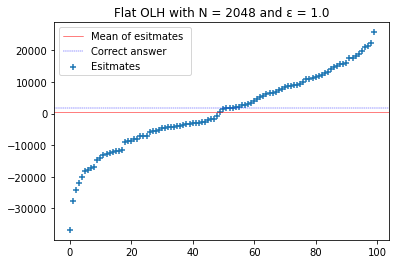

[1538.02198034 2068.92338502 1401.45049154 1371.25266849 2074.98932604
 2007.16516875 1606.70337083 1745.62654505 1636.50554779 1779.5386237
 1989.23110976 1946.76952265 2035.27507044 1690.83525286 1848.08813216
 1610.74733151 1860.61566028 1640.2857444  1699.45070234 1646.35168542
 2091.03328672 1709.29683997 1787.8243681  1620.46158711 1857.86832877
 1767.73644674 1576.43960677 2002.98932604 2290.15428398 1923.80238776
 1503.7142556  1801.45070234 1640.81327253 1781.8243681  1592.68139049
 1323.31860951 1578.59346914 1616.68139049 1717.38476133 1435.62633425
 1364.98890443 1813.71446641 2044.98932604 1874.24199453 1451.40653086
 1580.35168542 1805.56060404 1367.20870781 1586.61544948 1474.43960677
 1576.5714888  1531.95603932 1771.71446641 1976.90140469 2286.76973346
 1851.93426979 2067.09922773 1729.2528793  2051.31903112 1556.2857444
 1990.79150299 1656.72535117 1467.31860951 1592.54950846 1682.35168542
 1713.01109557 1928.30793555 1735.2528793  1588.5714888  1673.16495794
 1703.49

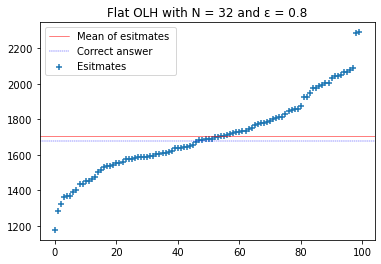

[2401.96406879 3793.29155098 1051.54517752 2396.10334787 3268.86610589
 2063.32642817  569.25901151 2770.96079188  412.1306172  1315.63330968
 2145.02610047  784.05770074 2571.72249587 1004.80524306 1692.63003277
 1739.39934462 1519.94124523 1516.16104861 1856.08813216 2321.52446202
 1192.64419445 2038.8868214  2218.75515017 1724.24918077 1234.34386676
 2804.66046419 1279.85311307  920.11645552  937.81612783 1864.49836154
 1644.63003277 2399.03370833 2995.48853081 1061.24484983 1692.63003277
 3388.4852539  1837.5386237   563.77914258 -926.94768423  372.1306172
 1543.53101584 2026.25678863 1592.79108138  990.88576737 2463.4733151
 1071.76498091 1297.52340799  610.10884766 2367.88354448 2465.17298741
 2823.62020203 1672.84983615 1676.21980339 2115.10662478  812.27750413
 1071.35475152 2793.73010373  599.58871659  882.22635721 1918.82806662
 2127.35580555 1417.58216276  316.92169858 2708.19148003 1425.17193338
 1396.54190061 1535.94124523 1017.81612783 1932.30793555 1471.50163846
 2544.76

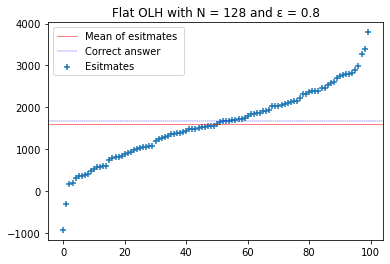

[-1469.42663934   -79.23279621  4752.69562181 -5351.35400333
  6410.58205641 -2368.46611944  5598.8503801   -873.46440664
  1354.03803081   587.69101042 14918.47613272  4821.15726162
   863.07592986 -8419.24201897  8309.43032845  1185.96091516
  1441.53809668   264.80602512 -2139.61969195   117.69048341
 -2092.11962607  2842.69351375 -2356.35070949 -5108.08449385
  4768.08027773  2000.00026351  6271.15884266   -93.6558782
  3369.2325327  -8920.20411992 -1693.84998484  1308.84563697
  1767.88459005  5178.46532892  8682.12305167  1312.11488294
 -3684.62140475  3876.7331256   2886.92433365  2290.76983886
  1767.69232796  7063.08278105 -2913.85130238  -394.42545356
  -584.61797915 -4202.31425973  -919.8106365  -5466.35413508
  1852.8847218   1456.92275261  -234.04066588  2108.26964123
  2708.84721801 -1772.50388674   874.03750379  -564.61797915
  1280.96104692  6075.38939906  -124.61745214  3349.2325327
 -2650.77405498  6770.96710759   582.11409242  5067.88827915
 -3683.46756873  3829.2330

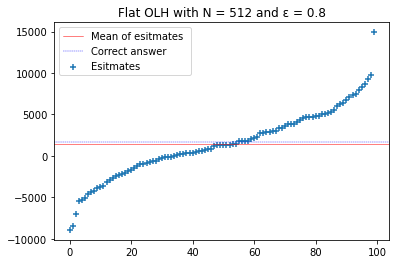

[  7726.35858931  24141.28654381  17818.83431408  -1764.91595221
  13307.6286512  -13071.21174894  -2199.95765942  -1335.24513027
  -8784.32503814 -17484.48324743  19104.99235352  -8263.34916654
  -7252.36450553   1783.64301713   5390.02349503  22591.95512593
 -20676.04732976  -5140.34836332  -1673.61090254    557.82294516
  12248.30602273  -3232.42586152   4895.9020498    8394.86482222
  17641.59510003  -9172.28700733  -9791.19704332   6747.26127249
 -23406.97350796  29221.80604575  29039.19594642  -7758.48595076
   1037.08996401  23941.30555921 -11595.81449545  -2432.16395566
   1305.63422772  27523.34806964 -15978.11891174 -10764.5855074
   1568.80760616   3836.57942133  -9989.91979846  -1214.56919533
 -13671.4926702  -40271.79759604 -14720.07352813  13926.53868719
   9553.37984453  25969.90399595  14480.99809989 -20010.05755576
  24527.99028355   1652.22531165   8137.06232906  34979.05709224
 -17789.3654786   -2931.65628616   9244.722925   -14235.43562399
  -7096.60883258  15454.38

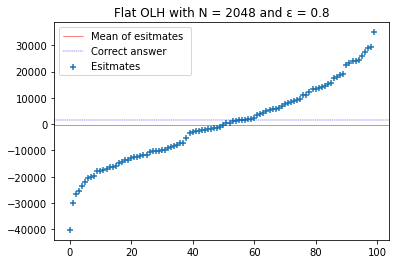

[1225.32217622 1506.00313794 1649.34518776 1884.0251035  1545.33368199
 1662.01255175 1703.34518776  803.95293094 1778.01464371 1798.69037553
 1257.97908042 1611.33995787 1966.69978934 1837.35669354 1475.33263601
 1662.00941381 1650.00313794 1533.99790804 1887.35878549 1711.34727972
 1560.67050192 2031.36819931 1965.36819931 1862.69142151 1397.99372412
 1946.03347133 1373.32636014 1612.01045979 1698.01568969 1636.01045979
 2100.70815718 1755.34937168 1800.68305367 1511.32949808 1492.00104598
 2178.72070893 1781.35146364 1635.34309581 1297.31903828 1187.97175856
 2044.70606522 1736.68828357 1779.35250962 1277.31380839 2038.69978934
 1577.33577395 1638.67050192 1680.67991574 1820.68828357 1524.
 1520.67259388 2028.03765525 1554.         2106.69874336 1634.0052299
 1512.66422605 1734.01568969 1680.67991574 1617.33681993 1732.68409965
 1479.99163217 1499.99686206 2362.05752886 1737.34937168 1879.35669354
 1904.02091958 1588.6715479  1879.3535556  2020.70292728 1716.01568969
 2030.03660927 

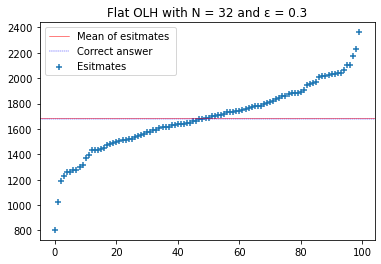

[  337.64993588  -392.41805277  1812.24023631   258.75697929
  -428.86714601   -40.60599012  2384.96094523  -322.6321396
  2959.45710754  1697.33681993  1836.90864627   884.3654149
   943.03905477  1720.89818648  2893.45187764  2108.26115589
  1620.21931672  3187.69734385  1796.01045979  1267.73884411
  2933.68165416  3295.70780364  2179.38388899  2594.52754168
   412.32357574  2155.38388899   689.90063198  1981.80683276
  2164.49093241   331.42538925  2103.3734292   2500.30299506
    77.17992305  -426.42328267  2617.65027478  2373.84867192
  3494.62167981 -1062.03694818   682.56904194  1306.63180069
 -1451.634924    1968.91910607   -45.05508336   172.97106612
  2118.93479575  1396.19839714  3041.46233744  2339.17503206
  1209.06520425  1659.11227331  1631.33159003  4520.27195459
   545.67085546  4600.50173111  2105.81729255  2718.76777799
  1714.0052299   1689.33681993   870.80927825   -65.94281005
  4269.80717166 -2153.25381941   252.53243267  3617.29531967
  1769.56659645   516.1147

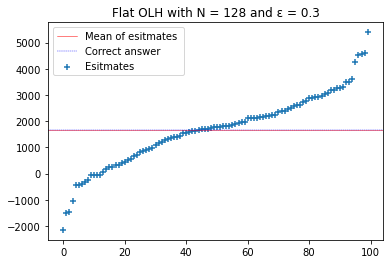

[  2416.31864239   3022.42056181   4824.48089625   1417.25582009
   2080.86689183  -1336.35818433  -3138.41851877   -490.43637859
  -3338.02168213   1258.69966225  19455.98187641   2282.34734327
    -95.8149106    4624.8777329   11313.47929803 -13167.56629031
   3028.88270861  -1511.37648897   7935.4239393    3985.02123731
   1470.18011369  -4809.21512473   4304.01084106   -899.6427053
  -3982.46303643  -9097.77714792  -6003.29625167  -5810.98551767
   1115.55864569  -6661.27545917   1711.66056512   3933.97423179
   1837.50915232   8416.72427705   3238.48587197 -10257.27341613
   3808.12564459   9876.04043158   8353.79998345  -7275.71681348
  12361.71183777   1795.63186424   3904.80451435   8774.05331568
   4569.24586866  -9489.69104527  -5931.20224063   1409.13310817
  -7200.9152318    7750.40563467  -4925.89399449  -1060.07615122
   6215.4576159    3481.84361148  12235.03296801   -861.51999338
  10139.3981711     606.96587859  -1093.00044482  -3907.66145476
   5697.69513135  12570.48

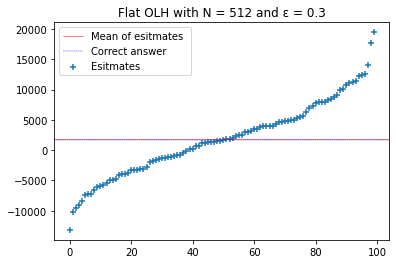

In [ ]:
epsilons = np.array([2,1.4,1,0.8,0.3])
n = np.array([32,128,512,2048])
number_of_qurries = 100
range_dates = ('2014-01-02','2014-01-9')   

for e in epsilons:
    for N in n:
        plot_name = 'plots/' + f'local_e={e}_N={N}.png'
        csv_name = 'results/' + f'local_e={e}_N={N}.csv'
        answers = plot_estimates_flat(number_of_qurries, N, HH_OLH_cc, e, all_dates, all_counts, range_dates, plot_name)
        np.savetxt(csv_name, answers, delimiter=',')

In [111]:
epsilons = np.array([2,1.4,1.2,1,0.8,0.7,0.5,0.4,0.3])
error_dicts = {}
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
for e in epsilons:
    print(e)
    number_of_queries = 100
    range_dates = ('2014-01-02','2014-01-9')
    answears = np.zeros(number_of_queries)
    corret_answear = np.sum(all_counts[0:8])
    for i in range(0,number_of_queries):
        local = HH_OLH_cc(e, test_dates, test_counts)
        a = local.answer(range_dates)
        answears[i] = a
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    #vfunc = np.vectorize(relative_error)
    #rel_erorrs = vfunc(answears, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error, 'abs': np.mean(error)}



2.0
1.4
1.2
1.0
0.8
0.7
0.5
0.4
0.3


In [112]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)
abs_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']
    abs_errors[num] = item[1]['abs']

In [113]:
error_stack = np.vstack((min_errors,mse_errors,max_errors,abs_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
abs_labels = np.full(abs_errors.size, 'abs errors')


labels_stack = np.vstack((min_labels,mse_labels,max_labels,abs_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons,epsilons)).flatten()


In [114]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('local_hh_seaborn_plotting_data.csv',index=False)

In [115]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors,'abs_errors':abs_errors})
all_data.to_csv('local_hh_plotting_data.csv',index=False)

In [116]:
sns.set()

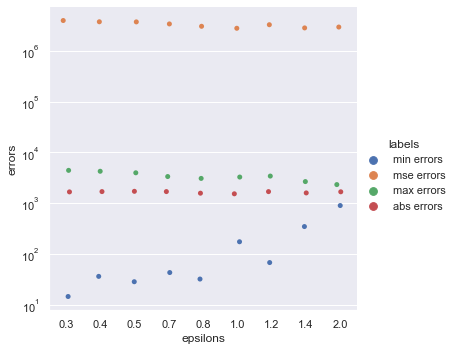

In [117]:
sns_plot = sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)
sns_plot.set(yscale="log")
sns_plot.savefig("local_hh_AllErrors.png")


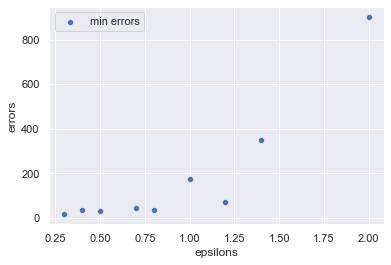

In [118]:
sns_plot = sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])
sns_plot.get_figure().savefig('con_min_error.png') 

In [119]:
epsilon = 1.
test_dates = all_dates[:128].copy()
test_counts = all_counts[:128].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears[i] = a





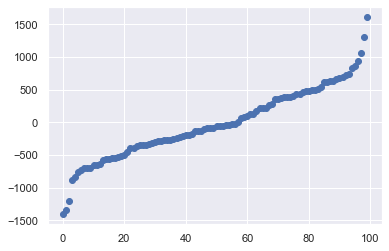

In [126]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears.sort()
plt.scatter(x,answears )
plt.show()

In [122]:
answears

array([  824.14385265, -1411.59587218,     8.5551265 ,  -707.22379051,
        -724.3340435 ,  -345.05676876,   -19.96196183,   285.17088327,
        -564.63834887,  -841.25410564,   268.06063027,   624.52423436,
         396.38752774,   225.28499778,  -296.5777186 ,  -205.32303595,
         459.12512206,  -573.19347537,  -390.68411008,   390.68411008,
         -39.92392366,  -268.06063027,   134.03031514,   541.82467821,
         861.21606747,   667.29986685,  -524.71442521,   353.61189525,
          65.58930315,  -265.20892144,  -761.40625833,    74.14442965,
         -99.80980914,   367.87043942,  -544.67638704,   633.07936086,
         -88.40297381,   -94.10639148,  -188.21278296,   516.15929872,
        1060.83568576,  -225.28499778,   499.04904572, -1346.00656903,
         -57.03417665, -1206.27283623,   -25.66537949,  -886.88144697,
         935.36049712,   125.47518864,  -134.03031514,  -692.96524634,
        -131.1786063 ,  -290.87430093,  -128.32689747,    94.10639148,
      

In [120]:
epsilon = 1.
test_dates = all_dates[:64].copy()
test_counts = all_counts[:64].copy()
number_of_queries = 100
range_dates = ('2014-01-02','2014-01-9')
answears_64 = np.zeros(number_of_queries)
corret_answear = np.sum(all_counts[0:8])
for i in range(0,number_of_queries):
    local = HH_OLH_cc(epsilon, test_dates, test_counts)
    a = local.answer(range_dates)
    answears_64[i] = a

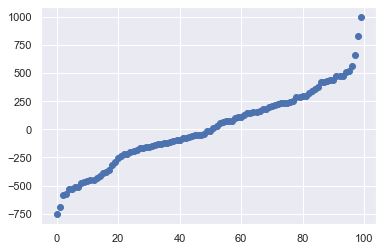

In [128]:
import matplotlib.pyplot as plt
x = np.arange(0,number_of_queries)
answears_64.sort()
plt.scatter(x,answears_64 )
plt.show()

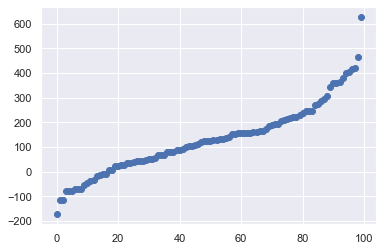

In [ ]:
print(np.argmax(all_counts))

In [96]:
class HH_OLH_degree:
    def __init__(self, epsilon, degree, dates, counts):
        """Setup of the datastructere
        Parameters:
        T (int): The lenght of the stream
        epsilon (float): The height of the full binary tree. 
        dates (Array): The dates of the stream
        counts (Array): The count for each of the dates
        Returns:
        A epsilon differintial datastructe
        """
        self.epsilon = epsilon
        self.all_dates = dates
        self.all_counts = counts
        #Check if we are we have missing dates.
        if len(dates) < (dates[-1]-dates[0]).days:
            #print('here')
            self.all_dates = self.__add_missing_dates(dates)
            self.all_counts = self.__add_missing_counts(counts,dates)
            
        #Make dict for date indexing
        values = np.arange(0,len(self.all_dates))
        zip_iterator = zip(self.all_dates, values)
        self.idx_dict =  dict(zip_iterator)
        
        self.degree = degree
        self.h = int(np.ceil(np.log(len(self.all_dates)) / np.log(degree)))
        self.level_prob = np.full(self.h+1,1/(self.h+1))
    
        self.tree_levels = self.__process(self.all_dates, self.all_counts)
        
    def __add_missing_dates(self, old_dates):
        """Add missing dates in a list
        Parameters:
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        start_date = dates[0]
        end_date = dates[-1]
        all_dates = pd.date_range(start = start_date, end = end_date).to_pydatetime().tolist()
        return [(date.date()) for date in all_dates]
    
    def __add_missing_counts(self, old_counts, old_dates):
        """Adds 0 to the list of counts where there was missing dates
        Parameters:
        old_counts (list of int): List counts for each day with 
        old_dates (list of datetime.date): List of dates that is not countious
        Returns:
        List of countious starting with the first value of 
        """
        zip_iterator = zip(old_dates, old_counts)
        missing_dict =  dict(zip_iterator)
        all_counts = np.zeros(len(self.dates))
        for i, date in enumerate(self.dates):
            val = missing_dict.get(date, 0)
            all_counts[i] = val
            
        return all_counts
    
    def __process(self, dates, counts):
        tree_levels = []
        for i in np.arange(0,self.h+1):
            level = np.zeros(int(self.degree**np.ceil(i)))
            tree_levels.append(level)
        
        for index, (date, day_count) in enumerate(zip(dates, counts)):
            #print(f'index = {index}, date = {date}, count = {day_count}')
            idxs = self.get_index(index,self.h)
            idxs.reverse()
            for person in range(int(day_count)):
                level = np.random.choice(np.arange(0, self.h+1), p = self.level_prob ) 
                tree_level = np.zeros(self.degree**level,dtype=int)
                
                if level != 0:
                    response = self.OLH_func(idxs[level], (self.degree**level))
                else:
                    response = 0
                tree_levels[level][response] = tree_levels[level][response] + 1

        return tree_levels

    def get_index(self, date_idx, n_layers):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        idx = []
        for i in np.arange(0,n_layers):
            if i == 0:
                idx.append(int(date_idx))
            else:
                idx.append(int(idx[i-1]//self.degree))
        idx.append(0)
        return idx
    
    def get_group(self, idx, n_layers, level):
        """Calculates the path of index in full binary string

        Parameters:
        date_idx (int): The node in the bouttom layer we want to calculate a path to. 
        The bottom layer has index from 0 to 2**h-1
        n_layers (int): The height of the full binary tree. 0 index

        Returns:
        list: of index in the path from the starting from the bottom and going up

        """
        if level == 0:
            return id
        elif idx == 0:
            return np.arange(0,self.degree)
        else:
            group_index = idx //self.degree
            level_indicis = np.arange(0,self.degree**level)

            split_ratio = (len(level_indicis) // self.degree)
            level_indicis_split = np.array_split(level_indicis, split_ratio)

            return level_indicis_split[group_index]
    
    def OLH_func(self, x, g):
        if np.random.uniform(0,1) < np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1):
            #print('if')
            return x
        else:
            #print('Uniform')
            return np.random.randint(low = 0, high = g)
    
    def OLH_aggre(self, count, N, g):
        p = np.exp(self.epsilon)/(np.exp(self.epsilon)+g-1)
        #print(p - 1/g)
        #print(f'p = {p}')
        return (count- N/g) / (p)
    
    def turns_right(self, path):
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]
            #print(f'current = {current}, nxt = {nxt}')
            if nxt == 0:
                #We went left
                #print('nxt == 0')
                direction_lst.append(0)
            elif current == 0 and current < nxt:
                #We went right
                #print('current == 0 and current < nxt')
                direction_lst.append(1)
            elif degree * current < nxt:
                #We went right
                #print('2* current < nxt')
                direction_lst.append(1)
            else:
                #print('else')            
                direction_lst.append(0)

        return direction_lst

    def turns_left(self, path):
        #print(path)
        #0 is left 1 is right
        direction_lst = []
        for i in range(len(path)-1):
            #print(f'i = {i}')
            current = path[i]
            nxt = path[i+1]
            #print(f'current = {current}, nxt = {nxt}')
            #Checks
            if nxt == 0:
                #We went left
                #print('nxt == 0')
                direction_lst.append(0)
            #Checks
            elif nxt == current*degree + degree - 1:
                #We went right
                #print(current * degree)
                #print(current * degree + degree)
                #print('current * degree != nxt')
                direction_lst.append(1)
            elif current == 0 and current < nxt:
                #We went left
                #print('current == 0 and current < nxt')
                direction_lst.append(0)
            else:
                #print('else')            
                direction_lst.append(0)

        return direction_lst
    
    def answer(self, dates):
        """Calculates the path of index in full binary string

        Parameters:
        dates (tuple of string): Two dates in the format string 2000-12-19. 

        Returns:
        float: The private range count
        """
            
        date_obj_0 = datetime.strptime(dates[0],'%Y-%m-%d').date()
        date_obj_1 = datetime.strptime(dates[1],'%Y-%m-%d').date()


        idx_0 = self.idx_dict[date_obj_0]
        idx_1 = self.idx_dict[date_obj_1]

        idx_left = idx_0-1
        idx_right = idx_1+1

        path_to_left = np.flip(np.array(self.get_index(idx_left,self.h)))
        path_to_right = np.flip(np.array(self.get_index(idx_right,self.h)))
        #Starting in 0
        if idx_0 == 0:

            left_or_right_list_rightside = self.turns_right(path_to_right)

            #level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            level_offset = 1
            sum_level = 0.0
            
            for i in range(len(left_or_right_list_rightside)):
                #print(f'i = {i}')
                #print(left_or_right)
                #print(f'We are looking at {left_or_right_list_rightside[i]}')
                if left_or_right_list_rightside[i] == 1:
                    #print(f'We are at level {i+level_offset}')
                    #print(f'We are at node {path_to_right[i+level_offset]} in the path')
                    #print('We went right')        
                    #print('We need to count the left one')
                    group = self.get_group(path_to_right[i+level_offset],0 , i+level_offset)
                    print(group)
                    idx_sss = np.where(group == path_to_right[i+level_offset])[0][0]
                    #print(idx_sss)
                    #print(group[:idx_sss])
                    #print(hhs[i+level_offset][group[:idx_sss]])
                    #print(hhs[i+level_offset][path_to_right[i+level_offset]-1])
                    count_nodes = self.tree_levels[i+level_offset][group[:idx_sss]]
                    print(count_nodes)
                    for node in count_nodes:
                        print(node)
                        contribution_level = self.OLH_aggre(node, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset]))
                        print(contribution_level)
    
        elif idx_1 == np.max(self.idx_dict.values):
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])
            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
        else:
            left_or_right_list_leftside = left_or_right_list(path_to_left[path_to_right != path_to_left])
            left_or_right_list_rightside = left_or_right_list(path_to_right[path_to_right != path_to_left])

            level_offset = len(path_to_left)-len(left_or_right_list((np.array(path_to_left)[path_to_right != path_to_left])))
            
            for i in range(len(left_or_right_list_leftside)):
                if left_or_right_list_leftside[i] == 0:
                    node = self.tree_levels[i+level_offset][path_to_left[i+level_offset]+1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    
            
            for i in range(len(left_or_right_list_rightside)):
                if left_or_right_list_rightside[i] == 1:
                    node = self.tree_levels[i+level_offset][path_to_right[i+level_offset]-1]
                    print('Node')
                    print(node)
                    #print('With all')
                    #print(self.OLH_aggre(node, self.epsilon, np.sum(self.all_counts), len(self.all_dates)))
                    print('with level')
                    print(self.tree_levels[i+level_offset])
                    print(self.OLH_aggre(node, self.epsilon, np.sum(self.tree_levels[i+level_offset]), len(self.tree_levels[i+level_offset])))
                    

        print(all_counts[idx_0:idx_1])
        print(f'Real answer is {np.sum(all_counts[idx_0:idx_1+1])}')
        #print(OLH_answer(count, epsilon, np.sum(OLH_count), D))
        #D = len(all_dates) 

query_dates = ('2014-01-02','2014-01-13')
epsilon = 0.7
degree = 4
local_HH = HH_OLH_degree(epsilon, degree, all_dates[:63], all_counts[:63])
local_HH.answer(query_dates)

for level in local_HH.tree_levels:
    print(level)


Paths
[ 0 -1 -1 -1]
[ 0  0  3 12]
[0 1 2 3]
[205. 223. 218.]
205.0
25.346338670613427
223.0
177.424370694294
218.0
135.1804729099383
[239. 118. 129.   2. 293. 362. 288. 250.  76.  89.   1.]
Real answer is 2100.0
[3180.]
[838. 753. 837. 891.]
[205. 223. 218. 207. 183. 186. 208. 221. 201. 179. 197. 214. 185. 201.
 193. 211.]
[59. 56. 50. 47. 62. 53. 55. 36. 42. 50. 54. 61. 45. 57. 43. 33. 44. 47.
 67. 54. 50. 54. 55. 42. 48. 48. 52. 58. 49. 43. 61. 38. 35. 61. 58. 55.
 59. 38. 54. 61. 62. 38. 44. 47. 44. 55. 48. 64. 52. 53. 51. 44. 47. 68.
 53. 58. 49. 48. 56. 47. 50. 59. 51. 65.]


7
7


In [ ]:
def max_disjoint_B_adic_ranges(r, B):
    # r = length, B = log base
    #Fact 3
    #Any sub-range of length[a,b]of length r from [D] can be decomposed into ≤ (B−1)(2 logBr+1)disjoint B-adic ranges.
    #(B−1)(2 logBr+1)
    return (B-1)*(2* np.log(r+1) / np.log(B))

In [ ]:
B = 2
r = 20
print(max_disjoint_B_adic_ranges(r,B))
n = 74088
exp = 42
np.log(n) / np.log(exp)